Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
#all imports
from __future__ import print_function
import subprocess
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from sklearn.metrics import confusion_matrix
from six.moves import range
import time
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
#%matplotlib inline

Loading the data and reshape it in a 4 dimension tensor

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save


image_size = 28
num_labels = 10
num_channels = 1 # grayscale

# reformating the dataset to be a 4 dimension tensor
def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28, 1) (200000, 10)
Validation: (10000, 28, 28, 1) (10000, 10)
Testing: (10000, 28, 28, 1) (10000, 10)


Data visualization
----

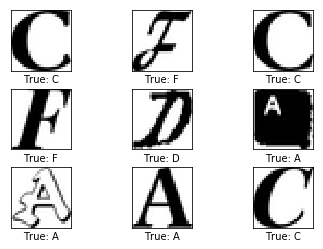

In [3]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

#getting the classes from the one-hot-labels
train_classes = np.argmax(train_labels, axis=1)
train_classes = [chr(i +ord('A')) for i in train_classes]

# the images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Get the first images from the test-set.
images = train_dataset[0:9]

# Get the true classes for those images.
cls_true = train_classes[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)  

# Number of classes, one class for each of 10 digits.
num_classes = 10

Useful functions
---

In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


Function to creat a convolutional layer with max pooling
-----

This is the model: 
---
2 convolutional layers and 4 connected layers


Tensorflow graph
----

In [13]:
batch_size = 128
patch_size = 6
num_filters_1 = 16
num_filters_2 = 32
hidden_nodes_1 = 60
hidden_nodes_2 = 40
hidden_nodes_3 = 20

class CNNModel:
     
    def __init__(self):
            """
            init
            """
            self.build_graph()

    def create_placeholders(self):           
        shape_X = (batch_size, image_size,image_size, num_channels)
        shape_Y =(batch_size, num_labels)
        name_X = 'X'
        name_Y = 'Y'
        self.tf_train_dataset = tf.placeholder(tf.float32, shape =shape_X ,name = name_X)
        self.tf_train_labels = tf.placeholder(tf.float32, shape=shape_Y, name = name_Y)

    def init_weights_biases(self,shape,weights_name,biases_name):
        layer = {\
            'weights':tf.Variable(tf.truncated_normal(shape, stddev=0.1),name=weights_name),
            'biases':tf.Variable(tf.zeros(shape[-1]),name=biases_name)}
        return layer

    def create_all_weights_bias(self):
            shape1 = [patch_size,
                      patch_size,
                      num_channels,
                      num_filters_1]
            self.conv_layer_1_wb = self.init_weights_biases(shape1,
                                                  "weights1",
                                                  "biases1")

            shape2 = [patch_size,
                      patch_size,
                      num_filters_1,
                      num_filters_2] 
            self.conv_layer_2_wb = self.init_weights_biases(shape2,
                                                  "weights2",
                                                  "biases2")

            shape3 = [image_size // 4 * image_size // 4 * num_filters_2,
                      hidden_nodes_1] 
            self.fully_hidden_layer_1 = self.init_weights_biases(shape3,
                                                       "weights3",
                                                       'biases3')
            shape4 = [hidden_nodes_1, hidden_nodes_2]
            self.fully_hidden_layer_2 = self.init_weights_biases(shape4,
                                                       "weights4",
                                                       'biases4')

            shape5 = [hidden_nodes_2, hidden_nodes_3] 
            self.fully_hidden_layer_3= self.init_weights_biases(shape5,
                                                      "weights5",
                                                      'biases5')
            shape6 = [hidden_nodes_3, num_labels]
            self.fully_hidden_layer_4 = self.init_weights_biases(shape6,
                                                       "weights6",
                                                       'biases6')      
    def create_summaries(self):
        #histogram summaries for weights
        tf.summary.histogram('weights1_summ',self.conv_layer_1_wb['weights'])
        tf.summary.histogram('weights2_summ',self.conv_layer_2_wb['weights'])
        tf.summary.histogram('weights3_summ',self.fully_hidden_layer_1['weights'])
        tf.summary.histogram('weights4_summ',self.fully_hidden_layer_2['weights'])
        tf.summary.histogram('weights5_summ',self.fully_hidden_layer_3['weights'])
        tf.summary.histogram('weights6_summ',self.fully_hidden_layer_4['weights'])

    def apply_conv(self,
                       input_tensor,
                       layer,
                       use_pooling=True):  # Use 2x2 max-pooling.
            """
            Create conv layer
            """

            weights = layer['weights']
            biases = layer['biases']

            # Create the TensorFlow operation for convolution.
            # Note the strides are set to 1 in all dimensions.
            # The first and last stride must always be 1,
            # because the first is for the image-number and
            # the last is for the input-channel.
            # But e.g. strides=[1, 2, 2, 1] would mean that the filter
            # is moved 2 pixels across the x- and y-axis of the image.
            # The padding is set to 'SAME' which means the input image
            # is padded with zeroes so the size of the output is the same.
            conv_layer = tf.nn.conv2d(input=input_tensor,
                                      filter=weights,
                                      strides=[1, 1, 1, 1],
                                      padding='SAME')

            # Add the biases to the results of the convolution.
            # A bias-value is added to each filter-channel.
            conv_layer += biases
            # Use pooling to down-sample the image resolution?
            if use_pooling:
                # This is 2x2 max-pooling, which means that we
                # consider 2x2 windows and select the largest value
                # in each window. Then we move 2 pixels to the next window.
                conv_layer = tf.nn.max_pool(value=conv_layer,
                                            ksize=[1, 2, 2, 1],
                                            strides=[1, 2, 2, 1],
                                            padding='SAME')
            conv_layer = tf.nn.relu(conv_layer)

            return conv_layer         
        
    def linear_activation(self,
                          input_tensor,
                          layer):
        """
        Method to computing linear activation
        """
        return tf.add(tf.matmul(input_tensor, layer['weights']),
                      layer['biases'])

    def forward_prop(self,
                     input_tensor,
                     V_hidden_layer_1,
                     V_hidden_layer_2,
                     V_hidden_layer_3,
                     V_hidden_layer_4,
                     V_hidden_layer_5,
                     V_hidden_layer_6):
        with tf.name_scope('Convolution_1'):
            conv_layer1 = self.apply_conv(input_tensor,V_hidden_layer_1,use_pooling=True)
        with tf.name_scope('Convolution_2'):
            conv_layer2 = self.apply_conv(conv_layer1,V_hidden_layer_2,use_pooling=True)
        with tf.name_scope('Reshape'):
            shape = conv_layer2.get_shape().as_list() 
            reshape = tf.reshape(conv_layer2, [shape[0], shape[1] * shape[2] * shape[3]])
        with tf.name_scope('Hidden_Layer_1'):
            hidden_la1 = tf.nn.relu(self.linear_activation(reshape,V_hidden_layer_3)) 
        with tf.name_scope('Hidden_Layer_2'):
            hidden_la2 = tf.sigmoid(self.linear_activation(hidden_la1,V_hidden_layer_4))
        with tf.name_scope('Hidden_Layer_3'):
            hidden_la3 = tf.sigmoid(self.linear_activation(hidden_la2,V_hidden_layer_5))     
        with tf.name_scope('Output_Layer'):
            logits = self.linear_activation(hidden_la3,V_hidden_layer_6) 
        return logits

    def create_loss(self):
        """
        Create the loss function of the model
        """
        with tf.name_scope("loss"):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits,
                                                                               labels=self.tf_train_labels))
            tf.summary.scalar(self.loss.op.name,self.loss)
 
    def sgd_train(self,
                  loss,
                  starter_learning_rate,
                  steps_for_decay,
                  decay_rate):
        global_step = tf.Variable(0, trainable=False)
        learning_rate = tf.train.exponential_decay(starter_learning_rate,
                                                   global_step,
                                                   steps_for_decay,
                                                   decay_rate,
                                                   staircase=True)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        return optimizer.minimize(loss, global_step=global_step)

    def create_optimizer(self):
        """
        Create the optimization of the model
        """
        with tf.name_scope("train"):
            self.optimizer = self.sgd_train(self.loss,
                                            0.9,
                                            100,
                                            0.96)         

    def create_predictions(self):
        self.train_prediction = tf.nn.softmax(self.logits, name='train_network')
        self.train_pred_cls = tf.argmax(self.train_prediction, dimension=1)
        self.valid_prediction = tf.nn.softmax(self.valid_network, name='valid_network')
        self.test_prediction = tf.nn.softmax(self.test_network, name='test_network')

    def create_accuracy(self):
        with tf.name_scope('accuracy'):
            self.train_prediction = tf.nn.softmax(self.logits, name='train_network')
            correct_pred = tf.equal(tf.argmax(self.train_prediction, 1), tf.argmax(self.tf_train_labels, 1))
            self.acc_op = tf.reduce_mean(tf.cast(correct_pred,'float'))        
        
    def build_graph(self):
        self.graph = tf.Graph() 
        with self.graph.as_default():

            #Placeholders
            self.create_placeholders()
            #Constants
            self.tf_valid_dataset = tf.constant(valid_dataset, name ='X_va')
            self.tf_test_dataset = tf.constant(test_dataset, name ='X_test')
            #all layers weights and biases
            self.create_all_weights_bias()
            self.t1 = self.conv_layer_1_wb['weights']
            self.t2 = self.conv_layer_1_wb['biases']
            self.tt1 = self.conv_layer_2_wb['weights']
            self.tt2 = self.conv_layer_2_wb['biases']
            self.tc1 = self.fully_hidden_layer_1['weights']
            self.tc2 = self.fully_hidden_layer_1['biases']
            self.tcc1 = self.fully_hidden_layer_2['weights']
            self.tcc2 = self.fully_hidden_layer_2['biases']
            self.te1 = self.fully_hidden_layer_3['weights']
            self.te2 = self.fully_hidden_layer_3['biases']
            self.tee1 = self.fully_hidden_layer_4['weights']
            self.tee2 = self.fully_hidden_layer_4['biases']
            #all summaries
            self.create_summaries()
            #forward propagation
            self.logits = self.forward_prop(self.tf_train_dataset,
                                  self.conv_layer_1_wb,
                                  self.conv_layer_2_wb,
                                  self.fully_hidden_layer_1,
                                  self.fully_hidden_layer_2,
                                  self.fully_hidden_layer_3,
                                  self.fully_hidden_layer_4)
            
            self.valid_network = self.forward_prop(self.tf_valid_dataset,
                                       self.conv_layer_1_wb,
                                       self.conv_layer_2_wb,
                                       self.fully_hidden_layer_1,
                                       self.fully_hidden_layer_2,
                                       self.fully_hidden_layer_3,
                                       self.fully_hidden_layer_4)
            
            self.test_network = self.forward_prop(self.tf_test_dataset,
                                       self.conv_layer_1_wb,
                                       self.conv_layer_2_wb,
                                       self.fully_hidden_layer_1,
                                       self.fully_hidden_layer_2,
                                       self.fully_hidden_layer_3,
                                       self.fully_hidden_layer_4)
            #loss
            self.create_loss()
            #opt
            self.create_optimizer()
            #predictions
            self.create_predictions()
            #accuracy
            self.create_accuracy()
            

In [15]:
#ALL VAriables and placeholders
log_basedir = 'logs'
run_label = time.strftime('%d-%m-%Y_%H-%M-%S') #e.g. 12-11-2016_18-20-45
log_path = os.path.join(log_basedir,run_label)
m = CNNModel()
num_steps = 1

initial_time = time.time()

with tf.Session(graph=m.graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
   
        # Pick an offset within the training data, which has been randomized.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {m.tf_train_dataset : batch_data, m.tf_train_labels : batch_labels}
        print(session.run(m.tf_train_dataset,feed_dict=feed_dict))
        print(session.run(m.tf_train_labels,feed_dict=feed_dict))
        print(session.run(m.t1,feed_dict=feed_dict))
        print(session.run(m.t2,feed_dict=feed_dict))
        print(session.run(m.tt1,feed_dict=feed_dict))
        print(session.run(m.tt2,feed_dict=feed_dict))
        print(session.run(m.tc1,feed_dict=feed_dict))
        print(session.run(m.tc2,feed_dict=feed_dict))
        print(session.run(m.tcc1,feed_dict=feed_dict))
        print(session.run(m.tcc2,feed_dict=feed_dict))
        print(session.run(m.te1,feed_dict=feed_dict))
        print(session.run(m.te2,feed_dict=feed_dict))
        print(session.run(m.tee1,feed_dict=feed_dict))
        print(session.run(m.tee2,feed_dict=feed_dict))


Initialized
[[[[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [ 0.11960784]
   [-0.19803922]
   [-0.5       ]]

  [[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [ 0.5       ]
   [ 0.2254902 ]
   [-0.5       ]]

  [[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [ 0.5       ]
   [ 0.07647059]
   [-0.5       ]]

  ..., 
  [[-0.5       ]
   [-0.5       ]
   [-0.49215686]
   ..., 
   [-0.19019608]
   [-0.5       ]
   [-0.49607843]]

  [[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [-0.5       ]
   [-0.49215686]
   [-0.49215686]]

  [[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [-0.48823529]
   [-0.49607843]
   [-0.5       ]]]


 [[[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [-0.26862746]
   [ 0.07647059]
   [-0.15882353]]

  [[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [ 0.5       ]
   [ 0.2764706 ]
   [-0.46470588]]

  [[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [ 0.4450980

In [16]:
#logits
log_basedir = 'logs'
run_label = time.strftime('%d-%m-%Y_%H-%M-%S') #e.g. 12-11-2016_18-20-45
log_path = os.path.join(log_basedir,run_label)
m = CNNModel()
num_steps = 1

initial_time = time.time()

with tf.Session(graph=m.graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
   
        # Pick an offset within the training data, which has been randomized.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {m.tf_train_dataset : batch_data, m.tf_train_labels : batch_labels}
        print(session.run(m.logits,feed_dict=feed_dict))

Initialized
[[ 0.13722591 -0.42817613 -0.08117278 ...,  0.03523119  0.06313569
  -0.00555433]
 [ 0.13632379 -0.42942616 -0.08575635 ...,  0.03557774  0.05991968
  -0.01211819]
 [ 0.14078397 -0.43178383 -0.08107589 ...,  0.03891521  0.06366557
  -0.01077212]
 ..., 
 [ 0.13994774 -0.42433229 -0.08693504 ...,  0.03361739  0.05805166
  -0.00692041]
 [ 0.13149042 -0.43246561 -0.09255605 ...,  0.02819347  0.06731059
  -0.01660879]
 [ 0.1362427  -0.43015057 -0.08238041 ...,  0.03280582  0.06179554
  -0.0125486 ]]


In [17]:
#constants
log_basedir = 'logs'
run_label = time.strftime('%d-%m-%Y_%H-%M-%S') #e.g. 12-11-2016_18-20-45
log_path = os.path.join(log_basedir,run_label)
m = CNNModel()
num_steps = 1

initial_time = time.time()

with tf.Session(graph=m.graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
   
        # Pick an offset within the training data, which has been randomized.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {m.tf_train_dataset : batch_data, m.tf_train_labels : batch_labels}
        print(session.run(m.tf_valid_dataset,feed_dict=feed_dict))
        print(session.run(m.tf_test_dataset,feed_dict=feed_dict))

Initialized
[[[[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [ 0.49215686]
   [ 0.5       ]
   [ 0.23333333]]

  [[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [ 0.31176472]
   [ 0.3392157 ]
   [ 0.08431373]]

  [[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [-0.48823529]
   [-0.5       ]
   [-0.5       ]]

  ..., 
  [[-0.5       ]
   [-0.49215686]
   [-0.5       ]
   ..., 
   [-0.5       ]
   [-0.5       ]
   [-0.5       ]]

  [[-0.5       ]
   [-0.5       ]
   [-0.49215686]
   ..., 
   [-0.5       ]
   [-0.5       ]
   [-0.5       ]]

  [[-0.5       ]
   [-0.5       ]
   [-0.5       ]
   ..., 
   [-0.5       ]
   [-0.5       ]
   [-0.5       ]]]


 [[[ 0.5       ]
   [ 0.5       ]
   [ 0.5       ]
   ..., 
   [-0.5       ]
   [-0.5       ]
   [-0.5       ]]

  [[ 0.13137256]
   [ 0.13529412]
   [ 0.12352941]
   ..., 
   [-0.5       ]
   [-0.5       ]
   [-0.5       ]]

  [[-0.5       ]
   [-0.49607843]
   [-0.5       ]
   ..., 
   [-0.5      

In [18]:
#constants
log_basedir = 'logs'
run_label = time.strftime('%d-%m-%Y_%H-%M-%S') #e.g. 12-11-2016_18-20-45
log_path = os.path.join(log_basedir,run_label)
m = CNNModel()
num_steps = 1

initial_time = time.time()

with tf.Session(graph=m.graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
   
        # Pick an offset within the training data, which has been randomized.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {m.tf_train_dataset : batch_data, m.tf_train_labels : batch_labels}
        print(session.run(m.valid_network,feed_dict=feed_dict))
        print(session.run(m.test_network,feed_dict=feed_dict))

Initialized
[[ 0.2734721  -0.24156116  0.03673472 ..., -0.17231134 -0.18172911
   0.17072716]
 [ 0.27202427 -0.23231871  0.03885259 ..., -0.16558921 -0.17832908
   0.1722438 ]
 [ 0.27282059 -0.23083945  0.03932489 ..., -0.1647839  -0.18193199
   0.17909953]
 ..., 
 [ 0.26842979 -0.22426018  0.04287065 ..., -0.16182539 -0.17790541
   0.17686117]
 [ 0.27265045 -0.22740681  0.0424087  ..., -0.16399659 -0.17930838
   0.17471737]
 [ 0.27373245 -0.23989606  0.03883404 ..., -0.17229563 -0.18083332
   0.16547903]]
[[ 0.27263662 -0.2322666   0.0365146  ..., -0.16669786 -0.17489615
   0.16796021]
 [ 0.27858487 -0.24485722  0.04403922 ..., -0.1772857  -0.1838752
   0.1673573 ]
 [ 0.26988605 -0.22851013  0.04470102 ..., -0.16523649 -0.18059248
   0.17473324]
 ..., 
 [ 0.2679964  -0.2362799   0.04072398 ..., -0.16913608 -0.1854147
   0.17510574]
 [ 0.2711221  -0.22989376  0.03971886 ..., -0.16572709 -0.17731711
   0.17213301]
 [ 0.26967674 -0.22570693  0.0418191  ..., -0.16048542 -0.18191397
   0.1

In [19]:
#loss
log_basedir = 'logs'
run_label = time.strftime('%d-%m-%Y_%H-%M-%S') #e.g. 12-11-2016_18-20-45
log_path = os.path.join(log_basedir,run_label)
m = CNNModel()
num_steps = 1

initial_time = time.time()

with tf.Session(graph=m.graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
   
        # Pick an offset within the training data, which has been randomized.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {m.tf_train_dataset : batch_data, m.tf_train_labels : batch_labels}
        print(session.run(m.loss,feed_dict=feed_dict))

Initialized
2.31098


In [20]:
#prediction
log_basedir = 'logs'
run_label = time.strftime('%d-%m-%Y_%H-%M-%S') #e.g. 12-11-2016_18-20-45
log_path = os.path.join(log_basedir,run_label)
m = CNNModel()
num_steps = 1

initial_time = time.time()

with tf.Session(graph=m.graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
   
        # Pick an offset within the training data, which has been randomized.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {m.tf_train_dataset : batch_data, m.tf_train_labels : batch_labels}
        print(session.run(m.train_prediction,feed_dict=feed_dict))
        print(session.run(m.train_pred_cls,feed_dict=feed_dict))        
        print(session.run(m.valid_prediction,feed_dict=feed_dict))
        print(session.run(m.test_prediction,feed_dict=feed_dict))        

Initialized
[[ 0.08935566  0.12448357  0.1062216  ...,  0.10395027  0.09486914
   0.07748746]
 [ 0.09002438  0.1248565   0.10563038 ...,  0.10408387  0.095392
   0.07795174]
 [ 0.0893115   0.12442534  0.10649552 ...,  0.10392871  0.09490911
   0.0773934 ]
 ..., 
 [ 0.08933998  0.12444712  0.10656527 ...,  0.10452928  0.09507175
   0.0776389 ]
 [ 0.08948349  0.12468912  0.10687196 ...,  0.10439339  0.09515715
   0.07768179]
 [ 0.08985561  0.12476162  0.10621189 ...,  0.1040139   0.09557515
   0.07781848]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 0.08996077  0.12422373  0.10664456 ...,  0.10452705  0.09514491
   0.07785553]
 [ 0.08964324  0.12439188  0.10628863 ...,  0.1044      0.09535608
   0.0776444 ]
 [ 0.08993725  0.12439105  0.10638526 ...,  0.10436641  0.0952590

In [21]:
#prediction
log_basedir = 'logs'
run_label = time.strftime('%d-%m-%Y_%H-%M-%S') #e.g. 12-11-2016_18-20-45
log_path = os.path.join(log_basedir,run_label)
m = CNNModel()
num_steps = 1

initial_time = time.time()

with tf.Session(graph=m.graph) as session:
    summary_writer = tf.summary.FileWriter(log_path, session.graph) 
    all_summaries = tf.summary.merge_all() 
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
   
        # Pick an offset within the training data, which has been randomized.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {m.tf_train_dataset : batch_data, m.tf_train_labels : batch_labels}
        print(session.run(m.acc_op,feed_dict=feed_dict))       

Initialized
0.132812


In [29]:
#full_test
log_basedir = 'logs'
run_label = time.strftime('%d-%m-%Y_%H-%M-%S') #e.g. 12-11-2016_18-20-45
log_path = os.path.join(log_basedir,run_label)
m = CNNModel()
num_steps = 10000

initial_time = time.time()

with tf.Session(graph=m.graph) as session:
    summary_writer = tf.summary.FileWriter(log_path, session.graph) 
    all_summaries = tf.summary.merge_all() 
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {m.tf_train_dataset : batch_data, m.tf_train_labels : batch_labels}
        
        #we are going to run the session and count the duration of the running
        start_time = time.time()
        _, l, predictions, acc, summary = session.run(
          [m.optimizer, m.loss, m.train_prediction, m.acc_op, all_summaries], feed_dict=feed_dict)
        duration = time.time() - start_time
       #writing the log
        summary_writer.add_summary(summary,step)
        summary_writer.flush()

        #Printing an overwiew
        if (step % 1000 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.2f%%" % (acc*100))
            print("Validation accuracy: %.1f%%" % accuracy(
            m.valid_prediction.eval(), valid_labels))
            print('Duration: %.3f sec' % duration)
            #print_test_accuracy()

    #after the loop compair our model with the test dataset    
    print("Test accuracy: %.1f%%" % accuracy(m.test_prediction.eval(), test_labels))


general_duration = time.time() - initial_time
sec = timedelta(seconds=int(general_duration))
d_time = datetime(1,1,1) + sec
print(' ')
print('The duration of the whole training with % s steps is %.2f seconds,'\
      % (num_steps,general_duration))
print("which is equal to:  %d:%d:%d:%d" % (d_time.day-1, d_time.hour, d_time.minute, d_time.second), end='')
print(" (DAYS:HOURS:MIN:SEC)")
print(' ')
print(log_path)
#!tensorboard --logdir=!!!copy log_path here!!!

Initialized
Minibatch loss at step 0: 2.317532
Minibatch accuracy: 14.06%
Validation accuracy: 10.0%
Duration: 0.126 sec
Minibatch loss at step 1000: 0.380012
Minibatch accuracy: 87.50%
Validation accuracy: 88.5%
Duration: 0.120 sec
Minibatch loss at step 2000: 0.314347
Minibatch accuracy: 89.84%
Validation accuracy: 89.9%
Duration: 0.139 sec
Minibatch loss at step 3000: 0.267827
Minibatch accuracy: 92.97%
Validation accuracy: 90.5%
Duration: 0.112 sec
Minibatch loss at step 4000: 0.248602
Minibatch accuracy: 92.19%
Validation accuracy: 90.8%
Duration: 0.129 sec
Minibatch loss at step 5000: 0.247150
Minibatch accuracy: 91.41%
Validation accuracy: 90.8%
Duration: 0.121 sec
Minibatch loss at step 6000: 0.235164
Minibatch accuracy: 95.31%
Validation accuracy: 90.9%
Duration: 0.114 sec
Minibatch loss at step 7000: 0.249656
Minibatch accuracy: 93.75%
Validation accuracy: 91.2%
Duration: 0.108 sec
Minibatch loss at step 8000: 0.174338
Minibatch accuracy: 93.75%
Validation accuracy: 91.2%
Dur

In [31]:
! tensorboard --logdir=logs/19-04-2017_13-24-47

Starting TensorBoard b'41' on port 6006
(You can navigate to http://127.0.1.1:6006)
^CTraceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 11, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/tensorboard/tensorboard.py", line 151, in main
    tb_server.serve_forever()
  File "/usr/lib/python3.5/socketserver.py", line 232, in serve_forever
    ready = selector.select(poll_interval)
  File "/usr/lib/python3.5/selectors.py", line 376, in select

    fd_event_list = self._poll.poll(timeout)
KeyboardInterrupt
